fix min_bw to a sound value

max,min,avg numbers of antennas  w.r.t (cluster size, subscription ratio)
min max capacity                 w.r.t (cluster size, subscription ratio)
costs 


**Initialization**

In [1]:
import seaborn as sns
import os
import networkx as nx
from pprint import pprint
import pandas as pd
import numpy as np
import random
import math as m
import glob
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
#from grave import plot_network
basedir = '../results_group_weighted'
basedir = '../results_relayedge'
basedir = '../results'
from tqdm.notebook import tqdm
def giant_component(g: nx.Graph) -> nx.Graph:
    return nx.subgraph(g, max(nx.connected_components(g), key=len))

from scipy.stats import t
def ci(series):
    return series.sem()*t.ppf((1 + 0.95) / 2., len(series)-1)

def to_csv_comment(df, path):
    with open(path, 'w') as fr:
        fr.write('#'+df.to_csv())

/tmp/ipykernel_1045391/2969672620.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Experimental Variables**

In [38]:
#CapEx costs
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, # 
    'fiber_deploy': 6000, # per km (aerial)
    'relay_router': 500, # 
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 554, #cost of LHG XL5 ac
    'mp_radio': 461 # cost of mANTBox 19
}

#OpEx costs
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_10': 31200, # yearly price for transport of 10Gbps [xarxaoberta.cat]
    'transport_100': 55200,  # yearly price for transport of 100Gbps [xarxaoberta.cat]
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}


power_consumption = {
    'leaf_radio': 26, # Watt
    'mp_radio': 24, # Watt
    'relay_router': 20, # Watt
    'gateway_router': 200, # Watt
}

cost_kw = 0.0003782 #Eur/W
power_factor = 0.7

#Reliability values
mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [mikrotik datasheet]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours [assumed]
}



#802.11ad technological values  
ad_table_1G_pro = [
  (0, 12, 3200),
  (-59, 11, 2700),
  (-61, 10, 2200),
  (-63, 9,  1950),
  (-68, 8, 830),
  (-70, 7, 550),
  (-72, 4, 300),
  (-74, 3, 260),
  (-75, 0, 0)
]

pt = 55 # (dBm) Maximum EIRP According to ETSI TR 102 555
gr_m = 20 # (dBi) received gain for wave ap micro
gr_d = 46 # (dBi) received gain for wave long range

max_bx = 2200   #max ch capacity at mcs10
mpant_bw = 90 #beamwidth of the mANTbox 19
mgb =  100


**Read Data**

In [39]:
##Read all the graphs
import re
# re.split('; |, |\*|\n',a)
graphs = []
#
files = glob.glob(f'{basedir}/*/*.wireless.graphml.gz')

for f in files:
    g = nx.read_graphml(f)
    f_g = nx.read_graphml(f.replace('wireless', 'fiber'))
    n_cust = sum([g.nodes[n]['subscriptions'] for n in g.nodes() if g.degree()[n] > 0])
    if n_cust==0:
        print(f)
        continue
    graphs.append((f.replace(basedir, ''),g,f_g,n_cust))

len(graphs)

../results/porcari_100_50_dijkstra_1/17128254993_58.wireless.graphml.gz


4421

**Simple Metrics**

In [40]:
def average_path_length(graph: nx.Graph):
    gws = [n for n in graph if 'type' in graph.nodes[n] and graph.nodes[n]['type'] == 'gateway']
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws)
    lengths = np.array(list(plenghts.values()))

    return lengths.mean(), lengths.max()

def get_clusters(graph: nx.Graph):
    cc = nx.connected_components(graph)
    sizes = []
    for c in cc:
        size = 0
        has_gw = False
        for n in c:
            if graph.nodes[n].get('type')=='gateway':
                has_gw = True
            size += graph.nodes[n]['subscriptions']
        if has_gw:
            sizes.append(size)
    return sizes

data = []
for (f,w_g,f_g, n_subs) in graphs:
    if n_subs==0:
        print(f)
        continue
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    measures['nodes'] = len(w_g)
    measures['n_gw'] = n_gw
    measures['algo'] = algo
    measures['subscriptions'] = n_subs
    measures['edges'] = len(w_g.edges())
    measures['avg_pathl'], measures['max_pathl'] = average_path_length(w_g)
    measures['area'] = area
    measures['ratio'] = int(ratio)
    measures['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
    measures['leaves'] = len([n for n in w_g.nodes() if w_g.degree()[n]==1])
    measures['relays'] = len([n for n in w_g.nodes() if w_g.degree()[n]>1]) - measures['gateways']
    measures['relays_ratio'] =  measures['relays']/n_subs
    unc = sum([d['subscriptions'] for n, d in w_g.nodes(data=True) if w_g.degree()[n] == 0])
    all_sub = sum([d['subscriptions'] for n, d in w_g.nodes(data=True)])
    measures['unc'] = unc
    measures['unconnected'] = unc/all_sub
    measures['cluster_size'] = int(cluster_size)
    measures['connected_components'] = get_clusters(w_g)
    measures['time'] = time
    measures['seed'] = random_seed
    data.append(measures)
    
df = pd.DataFrame(data)

Get the number of antennae and generate the table

**CapEx**

In [41]:
def calc_cost_fiber(g):
    return sum([d['length'] for s,t,d in g.edges(data=True)])*1e-3*capex_costs['fiber_deploy']

def phi(g, n):
    #Find the size of the occupied beam and see how many antennas are needed to cover it.
    thisnode = g.nodes[n]
    beams = []
    for neigh in g[n]:
        thisneigh = g.nodes[neigh]
        beam = m.degrees(m.atan2(thisneigh['x'] - thisnode['x'], thisneigh['y']-thisnode['y'])) % 360
        beams.append(beam)
    beams.sort()
    try:
        beams.append(beams[0])
    except:
        print(g[n])
    beams = np.array(beams)
    
    diff = (beams[1:] - beams[:-1] -0.0001) % 360
    width = 360 - diff.max()    
    return width

def calc_antennas(g, n, gw):
    phi_v = m.ceil(phi(g, n)/mpant_bw)
    n_paths = sum([n['paths'] for n in g[n].values()])
    if not gw:
        #Relay nodes needs double of the BW
        k=1 #TODO: check this
    else: 
        k=1
    d_v = m.ceil(n_paths*k*mgb/max_bx)
    return max(phi_v, d_v)

def compute_paths(g, gws):
    for e in g.edges():
        g.edges[e]['paths'] = 0
    
    ## For each edge where a SP pass accumulate a value
    
    paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
    for k,path in paths.items():
        n_subs = g.nodes(data=True)[k]['subscriptions']
        for i in range(len(path)-1):
            g.edges[path[i], path[i+1]]['paths'] += n_subs
    for e in g.edges():
        if(g.edges[e]['paths'] == 0):
            ## For redundancy link assume a single path
            g.edges[e]['paths'] = 1
            g.edges[e]['redundant'] = 1
        else:
            g.edges[e]['redundant'] = 0
        g.edges[e]['bw'] = mgb * g.edges[e]['paths']
    

def calc_cost_wireless(g) -> list[float]:
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    compute_paths(g, gws)
                 
    ## Multiplicate the value by the BW needed for each node
    ## Calculate the cost of each edge
    
    for n in g.nodes():
        #If it's unconnected it does not cost
        if nx.degree(g)[n] == 0:
            g.nodes[n]['router_cost'] = 0
            g.nodes[n]['deploy'] = 0
            g.nodes[n]['fiber_cost'] = 0
            g.nodes[n]['radio_cost'] = 0
            continue
        #If it's a GW
        if g.nodes[n].get('type') == 'gateway':
            g.nodes[n]['router_cost'] = capex_costs['gateway_router'] 
            #loc = (g.nodes[n]['x'], g.nodes[n]['y'])
            #g.nodes[n]['fiber_cost' ] = capex_costs['fiber_deploy']*road_distance(fiber_points[area], loc)
            g.nodes[n]['deploy'] = capex_costs['gateway_deploy']
            g.nodes[n]['n_ant'] =  calc_antennas(g, n, True)
            #print(g.nodes[n]['n_ant'])
            g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant']
        else:
            g.nodes[n]['fiber_cost' ] = 0
            if g.degree()[n] == 1:
                #leaf node, no router
                g.nodes[n]['radio_cost'] = capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['leaf_deploy']
                g.nodes[n]['router_cost'] = 0
                g.nodes[n]['n_ant'] = 1
            else:
                #relay node
                g.nodes[n]['n_ant'] = calc_antennas(g, n, False) 
                #Relays are leaves with additional antennas
                g.nodes[n]['radio_cost'] = capex_costs['mp_radio'] * g.nodes[n]['n_ant'] + capex_costs['leaf_radio']
                g.nodes[n]['deploy'] = capex_costs['relay_deploy']
                g.nodes[n]['router_cost'] = capex_costs['relay_router']
        
        
    router_cost = sum([g.nodes[n]['router_cost'] for n in g.nodes()])
    deploy = sum([g.nodes[n]['deploy'] for n in g.nodes()])
    radio_cost = sum([g.nodes[n]['radio_cost'] for n in g.nodes()])

    return [router_cost, deploy, radio_cost]
  

In [42]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs[:]:
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    costs = calc_cost_wireless(w_g)
    costs.append(calc_cost_fiber(f_g))
   
    type_costs = ['router_cost', 'deploy', 'radio_cost', 'fiber_cost']
    total_cost = sum(costs)
    data_summed.append({'capex': total_cost/n_subs/5/12,
                        'area': area, 
                        'cluster_size': cluster_size,
                        'ratio':ratio,
                        'algo': algo,
                        'n_gw': n_gw})

    for i in range(4):
        measures = {}
        measures['nodes'] = len(w_g)
        measures['n_gw'] = n_gw
        measures['cost'] = costs[i]
        measures['algo'] = algo
        measures['cost_customer'] = costs[i]/n_subs
        measures['5ymontlycostcustomer'] = costs[i]/n_subs/5/12
        measures['type_cost'] = type_costs[i]
        measures['area'] = area
        measures['ratio'] = ratio
        measures['cluster_size'] = cluster_size
        measures['time'] = time
        measures['seed'] = random_seed
        measures['n_gw'] = n_gw

        data.append(measures)
        
edf = pd.DataFrame(data)
sedf = pd.DataFrame(data_summed)

Get the number of antennae and generate the table

**OpEx**

In [43]:
def calc_opex_fiber_network(g):
    #Fiber opex
    total_bw = sum([d['subscriptions'] for n,d in g.nodes(data=True)])*mgb/1000 #Gbps of mgb
    fiber_transit = m.ceil(total_bw)*opex_costs['bw']
    if total_bw < 10:
        fiber_trasport = opex_costs['transport_10']
    # if total_bw < 20:
    #     fiber_trasport = 2*opex_costs['transport_10']
    elif total_bw < 100:
        fiber_trasport = opex_costs['transport_100']
    elif total_bw < 200:
        fiber_trasport = 2*opex_costs['transport_100']
    elif total_bw < 300:
        fiber_trasport = 3*opex_costs['transport_100']
    elif total_bw < 400:
        fiber_trasport = 4*opex_costs['transport_100']
    else:
        raise ValueError(f"Can't relay more than 200G : {total_bw}")
    return fiber_transit, fiber_trasport

def calc_opex_maintenance(g, kind):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']
    p_leaf = len(leafs)/len(g)
    p_relay = len(relays)/len(g)
    p_radio_failure = (364*24)/mttf['radio']
    p_router_failure = (364*24)/mttf['router']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_maintenance = p_router_failure * len(gws) * (mttr['router'] * opex_costs[kind] + capex_costs['gateway_router'])
    router_maintenance = p_router_failure  * len(relays) * (mttr['router'] * opex_costs[kind] + capex_costs['relay_router'])
    leafs_maintenance = p_leaf * p_radio_failure * len(leafs) * (mttr['radio'] * opex_costs['planned_maintenance'] + capex_costs['leaf_radio'])
    relays_maintenance = p_relay * p_radio_failure * n_tot_ants * (mttr['radio'] * opex_costs[kind] + capex_costs['mp_radio'])
    return gw_maintenance + router_maintenance + leafs_maintenance + relays_maintenance
    

def calc_opex_power_consumption(g):
    #Maintenance opex
    relays = [n for n in g if  g.degree[n] > 1]
    leafs = [n for n in g if  g.degree[n] == 1]
    gws = [n for n in g if 'type' in g.nodes[n] and g.nodes[n]['type'] == 'gateway']

    n_tot_ants = sum([g.nodes[n]['n_ant'] for n in relays])
        
    gw_consumption = power_consumption['gateway_router'] * len(gws) * 24* 365 * cost_kw * power_factor
    router_consumption = power_consumption['relay_router']  * 24* 365 * cost_kw * power_factor
    leafs_consumption = power_consumption['leaf_radio'] * len(leafs) * 24* 365 * cost_kw * power_factor
    relays_consumption = power_consumption['mp_radio'] * n_tot_ants * 24* 365 * cost_kw * power_factor
    return gw_consumption + router_consumption + leafs_consumption + relays_consumption
    
    

In [44]:
data = []
data_summed = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    
    fiber_cost, transport_cost = calc_opex_fiber_network(w_g)
    cost_types = ['fiber', 'planed_maintenance', 'unplanned_maintenance']
    planned_maint = calc_opex_maintenance(w_g, 'planned_maintenance')
    unplanned_maint = calc_opex_maintenance(w_g, 'unplanned_maintenance')
    power_consumpt = calc_opex_power_consumption(w_g)

    data.append({'fiber_cost': fiber_cost/n_subs/12,
                 'algo': algo,
                 'transport_cost': transport_cost/n_subs/12,
                 'unplanned_cost':  unplanned_maint/n_subs/12,
                 'power_consumption': power_consumpt/n_subs/12,
                 'area': area, 
                 'cluster_size': cluster_size,
                 'ratio':ratio,
                 'n_gw': n_gw})    

opdf = pd.DataFrame(data)

Overall cost for cluster = 200 over customer ratio

In [45]:

costs = opdf[(opdf.cluster_size==200)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost', 'power_consumption']].agg(['mean', ci])
capex = sedf[(sedf.cluster_size==200)].groupby('ratio')['capex'].agg(['mean', ci])
costs['capex', 'mean'] = capex['mean']
costs['capex', 'ci'] = capex['ci']
costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]
costs['recurring'] = costs['fiber_cost_mean'] + costs['transport_cost_mean'] + costs['unplanned_cost_mean']
costs['sum'] = costs['recurring'] + costs['capex_mean']

costs.index = costs.index/100
to_csv_comment(costs, f'../processed/costs_1_dijkstra.csv')
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)

print(costs[[i for i in costs.columns if "sum"==i]])

             sum
ratio           
0.25   63.421373
0.50   50.694033
1.00   39.801127


Overall cost for cluster = 50 over customer ratio

In [57]:

costs = opdf[(opdf.cluster_size==100)].groupby('ratio')[['fiber_cost', 'transport_cost', 'unplanned_cost', 'power_consumption']].agg(['mean', ci])
capex = sedf[(sedf.cluster_size==100)].groupby('ratio')['capex'].agg(['mean', ci])
costs['capex', 'mean'] = capex['mean']
costs['capex', 'ci'] = capex['ci']
costs.columns = ["_".join(a) for a in costs.columns.to_flat_index()]
costs['recurring'] = costs['fiber_cost_mean'] + costs['transport_cost_mean'] + costs['unplanned_cost_mean']
costs['sum'] = costs['recurring'] + costs['capex_mean']

costs.index = costs.index/100
print(costs[[i for i in costs.columns if "sum"==i]])

             sum
ratio           
0.25   69.112395
0.50   50.808221
1.00   41.370366


**Offered Bandwidth**

In [47]:

def calc_ad_speed(dist, freq=70, ptp=False):
    pl = 20*np.log10(dist/1000) + 20*np.log10(freq) + 92.45
    pt = 55 # (dBm) Maximum EIRP According to ETSI TR 102 555
    gr_m = 20 # (dBi) received gain for wave ap micro
    gr_d = 46 # (dBi) received gain for wave long range
    ad_table=ad_table_1G_pro
    if ptp:
        pr = pt + gr_d - pl
    else:
        pr = pt + gr_m - pl
    speed = 0
    for i in range(len(ad_table)):
        if pr<ad_table[i][0]:
            speed = ad_table[i][2]
    return speed

def calc_maxbw(g, p):
    bws = []
    for i in range(len(p)-1):
        n=p[i]
        n1 = p[i+1]
        bws.append(calc_ad_speed(w_g[n][n1]['dist']))
    return min(bws)

def calc_minbw(g, p):
    bws = []
    print(p)
    for i in range(len(p)-1):
        n=p[i]
        n1 = p[i+1]
        bw = calc_ad_speed(w_g[n][n1]['dist'])
        paths = w_g[n][n1]['paths']
        print(n, n1, bw, paths)
        bws.append(bw/paths)
    return min(bws)



**Offered Bandwidth**

In [48]:

def calc_ad_speed(dist, freq=70, ptp=False, pro=True):
    pl = 20*np.log10(dist/1000) + 20*np.log10(freq) + 92.45
    pt = 55 # (dBm) Maximum EIRP According to ETSI TR 102 555
    gr_m = 20 # (dBi) received gain for wave ap micro
    gr_d = 46 # (dBi) received gain for wave long range
    if pro:
        ad_table=ad_table_1G_pro
    else:
        ad_table=ad_table_1G_lite
    if ptp:
        pr = pt + gr_d - pl
    else:
        pr = pt + gr_m - pl
    speed = 0
    for i in range(len(ad_table)):
        if pr<ad_table[i][0]:
            speed = ad_table[i][2]
    return speed

def calc_maxbw(g, p):
    bottleneck = ad_table_1G_pro[0][2] #initalize to maximum value (400mbps)
    for i in range(len(p)-1):
        speed = calc_ad_speed(w_g[p[i]][p[i+1]]['dist'])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw_gab(g, path):
    #print("nodes", path)
    uplinks = []
    downlinks = []
    #print("node ul_paths dl_paths ul_capacity dl_capacity # pred #succ")
    for p_i in range(len(path)-1):
        p0 = path[p_i]
        p1 = path[p_i+1]
        #print(p0, p1,  g[p0][p1]['paths'], g.nodes[p0]['paths'], g.nodes[p0]['uplink_capacity'], g.nodes[p0]['downlink_capacity'], len(list(g.predecessors(p0))), len(list(g.successors(p0))))
        #print(p1, g.nodes[p1]['paths'], g.nodes[p1]['uplink_capacity'], g.nodes[p1]['downlink_capacity'], len(list(g.predecessors(p1))), len(list(g.successors(p1))))
        
        downlinks.append(g.nodes[p1]['downlink_capacity']/g.nodes[p1]['paths'])
        uplinks.append(g.nodes[p0]['uplink_capacity']/g[p0][p1]['paths'])
    # print("paths", [g.nodes[p]['paths'] for p in path])
    # print("ants", [g.nodes[p]['n_ant'] for p in path])
    # print("ul", [g.nodes[p]['uplink_capacity'] for p in path])
    
    # print("dl", [g.nodes[p]['downlink_capacity'] for p in path])
    uplink = min(uplinks)
    downlink = min(downlinks)
    return uplink, downlink, min(uplink, downlink)



In [49]:
mac_efficiency = 0.84

data = []
for g_id, (f,w_g,f_g, n_subs) in enumerate(graphs[:]):
    #print(g_id, len(graphs))
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    paths = nx.multi_source_dijkstra_path(w_g, gws, weight='dist')
    speeds = []
    T = nx.DiGraph()
    T.add_nodes_from((i, w_g.nodes[i]) for i in w_g.nodes)
    for src, p in paths.items():
        p.reverse()
        for i in range(len(p)-1):
            T.add_edge(p[i], p[i+1], **w_g[p[i]][p[i+1]])
    
    for n in T.nodes():
        if T not in gws:
            caps_uplink = []
            caps_downlink = []
            T.nodes[n]['bottleneck_uplink'] = np.nan
            T.nodes[n]['bottleneck_downlink'] = np.nan
            T.nodes[n]['downlink_capacity'] = np.nan
            T.nodes[n]['uplink_capacity'] = np.nan
            n_paths = 0
            for neigh in T.predecessors(n):
                caps_downlink.append(calc_ad_speed(T[neigh][n]['dist']))
                n_paths += T[neigh][n]['paths']
            for neigh in T.successors(n):
                caps_uplink.append(calc_ad_speed(w_g[n][neigh]['dist']))
            assert(len(caps_uplink)<=1)
            if caps_uplink:
                T.nodes[n]['uplink_capacity'] = caps_uplink[0]
                #T.nodes[n]['bottleneck_uplink'] = T.nodes[n]['uplink_capacity'] / n_paths
            
            if caps_downlink:
                T.nodes[n]['downlink_capacity'] = np.mean(caps_downlink)*(T.nodes[n]['n_ant']-1)
                #T.nodes[n]['bottleneck_downlink'] = T.nodes[n]['downlink_capacity'] / n_paths
            
            
            T.nodes[n]['paths'] = n_paths


    
    for src, p in paths.items():
        if src in gws:
            continue
        #print(src)
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(T, p)
        
        max_bw = calc_maxbw(T, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['algo'] = algo
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
            run['n_gw'] = n_gw
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            data.append(run | {'bw_type': 'min_ul', 'bw': mac_efficiency*min_bw[0]})
            data.append(run | {'bw_type': 'min_dl', 'bw': mac_efficiency*min_bw[1]})
            data.append(run | {'bw_type': 'min', 'bw': mac_efficiency*min_bw[2]})
            data.append(run | {'bw_type': 'max', 'bw': mac_efficiency*max_bw})
            # run['max_bw'] = mac_efficiency*max_bw
            # run['min_bw_ul'] = mac_efficiency*min_bw[0]
            # run['min_bw_dl'] = mac_efficiency*min_bw[1]
            # run['min_bw'] = mac_efficiency*min_bw[2]
            #data.append(run)

bwdf = pd.DataFrame(data)

/home/gabriel/Envs/odcm/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/gabriel/Envs/odcm/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/gabriel/Envs/odcm/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/gabriel/Envs/odcm/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1

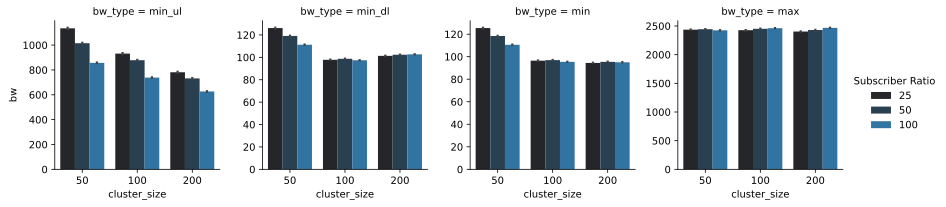

In [64]:
fg = sns.FacetGrid(data=bwdf, col='bw_type', sharey=False)
fg.map_dataframe(sns.barplot, x='cluster_size', y='bw', hue='ratio')
fg.add_legend(title="Subscriber Ratio")


In [52]:
data = []
data_summed = []
   
for (f,w_g,f_g, n_subs) in graphs[:]:
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    
    cluster_size = int(cluster_size)
    ratio = int(ratio)
    measures = {'n_gw': n_gw,
                'algo': algo,
                'ratio': ratio,
                'cluster_size': cluster_size,
                'n_ant': 0}
    for n,d in w_g.nodes(data=True):
        if w_g.degree(n) > 1:
            measures['n_ant']+=d['n_ant']
    data.append(measures)

n_ant_df = pd.DataFrame(data)

Get the number of antennae and generate the table

In [53]:
df['avg_cc'] = df.connected_components.apply(np.mean)
a = n_ant_df.groupby(['n_gw', 'algo', 'ratio', 'cluster_size']).mean()
b = df.groupby(['n_gw', 'algo', 'ratio', 'cluster_size']).mean(numeric_only=True)
b.join(a)[['nodes', 'subscriptions', 'edges', 'avg_pathl', 'gateways', 'relays', 'leaves', 'unc', 'avg_cc', 'n_ant']]
#.to_latex('../processed/table.tex', float_format="{:0.2f}".format)



nodes  subscriptions       edges  \
n_gw algo     ratio cluster_size                                          
1    dijkstra 25    50            297.096774     366.552419  309.629032   
                    100           296.212551     361.374494  319.465587   
                    200           297.309426     371.454918  340.520492   
              50    50            484.911111     714.145455  500.145455   
                    100           497.889571     747.220859  546.889571   
                    200           499.160494     737.047325  556.030864   
              100   50            669.066802    1223.925101  673.580972   
                    100           757.351515    1476.062626  820.004040   
                    200           762.008264    1504.741736  862.981405   

                                  avg_pathl   gateways      relays  \
n_gw algo     ratio cluster_size                                     
1    dijkstra 25    50             1.476441   8.308468   65.582661   
                    100            1.666848   4.400810   70.032389   
                    200            1.992678   2.309426   73.241803   
              50    50             1.415745  15.646465  101.050505   
                    100            1.572050   8.339468  112.533742   
                    200            1.768623   4.430041  115.596708   
              100   50             1.387816  26.305668  131.091093   
                    100            1.487546  15.957576  163.698990   
                    200            1.634746   8.318182  173.543388   

                                      leaves        unc      avg_cc  \
n_gw algo     ratio cluster_size                                      
1    dijkstra 25    50            205.762097  22.981855   42.370193   
                    100           199.267206  27.753036   76.204594   
                    200           205.620902  18.881148  155.068613   
              50    50            342.820202  42.690909   44.374042   
                    100           354.705521  34.983640   86.437092   
                    200           345.973251  47.325103  155.574789   
              100   50            475.807692  75.558704   46.080295   
                    100           546.448485  69.684848   89.813944   
                    200           550.448347  56.516529  174.566441   

                                       n_ant  
n_gw algo     ratio cluster_size              
1    dijkstra 25    50            163.707661  
                    100           175.676113  
                    200           192.053279  
              50    50            255.284848  
                    100           287.691207  
                    200           307.868313  
              100   50            337.038462  
                    100           427.321212  
                    200           476.039256

In [54]:

data = []
for (f,w_g,f_g, n_subs) in graphs:
    measures = {}
    area, ratio, cluster_size, algo, n_gw, time, random_seed = re.split('[._/]', f)[1:8]
    cluster_size = int(cluster_size)
    ratio = int(ratio)

    gws = [n for n in w_g if 'type' in w_g.nodes[n] and w_g.nodes[n]['type'] == 'gateway']
    
    for n in w_g.nodes():
        if w_g.degree()[n] > 0:
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            if n in gws:
                run['type'] = 'gw'
            elif w_g.degree()[n]==1:
                run['type'] = 'leaf'
            else:
                run['type'] = 'relay'
            run['antennae'] =  w_g.nodes[n]['n_ant']
            run['degree'] = w_g.degree()[n]
            run['n_gw'] = n_gw
            run['algo'] = algo
            run['area'] =  area
            data.append(run)
            

ant_node = pd.DataFrame(data)

In [59]:
ant_node.groupby(['type', 'cluster_size','ratio' ]).antennae.mean()

type   cluster_size  ratio
gw     50            25       3.284640
                     50       3.204893
                     100      3.086254
       100           25       4.324747
                     50       4.600539
                     100      4.607890
       200           25       7.744454
                     50       7.972596
                     100      8.495529
leaf   50            25       1.000000
                     50       1.000000
                     100      1.000000
       100           25       1.000000
                     50       1.000000
                     100      1.000000
       200           25       1.000000
                     50       1.000000
                     100      1.000000
relay  50            25       2.080082
                     50       2.030350
                     100      1.952760
       100           25       2.236733
                     50       2.215511
                     100      2.161656
       200           25       2.37798